In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

In [7]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

def show_tables():
    query = """
                SELECT
                    name,
                    type
                FROM sqlite_master
                WHERE type IN ('table','view');"""
    return run_query(query)

In [10]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [41]:
query_31 = """WITH track_gen AS (
                SELECT
                    t.track_id,
                    g.name genre
                FROM track t
                LEFT JOIN genre g ON t.genre_id = g.genre_id),
                track_count AS (
                SELECT
                    i.track_id,
                    SUM(i.quantity) track_ct,
                    tg.genre
                FROM invoice_line i
                INNER JOIN track_gen tg ON tg.track_id = i.track_id
                GROUP BY 3
                )
                SELECT 
                    genre,
                    track_ct,
                    ROUND(CAST(track_ct as Float) / (SELECT SUM(track_ct) FROM track_count) * 100, 2) percentage
                FROM track_count
                
                    
"""


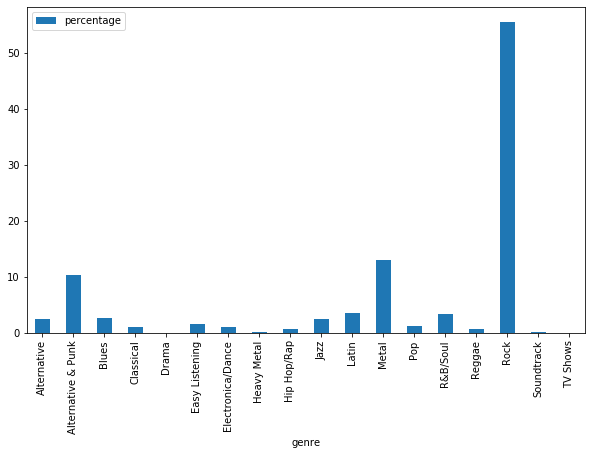

In [45]:
run_query(query_31).plot.bar(x='genre', y='percentage', figsize=(10,6))

In [216]:
query_41 = """
            WITH empid_sales AS (
                SELECT
                    c.support_rep_id id,
                    SUM(invoice.total) sales,
                    SUM(invoice.total) / CAST(COUNT(invoice.invoice_id) AS Float) value_per_order
                FROM invoice
                LEFT JOIN customer c ON c.customer_id = invoice.customer_id
                GROUP BY 1)
            SELECT
                e.employee_id,
                e.first_name ||" "|| e.last_name name,
                e.title,
                e.hire_date,
                emp_s.sales,
                emp_s.value_per_order
            FROM employee e
            INNER JOIN empid_sales emp_s ON emp_s.id = e.employee_id
            WHERE e.title = 'Sales Support Agent'                
"""

In [217]:
run_query("SELECT DISTINCT title FROM employee")

,title
0,General Manager
1,Sales Manager
2,Sales Support Agent
3,IT Manager
4,IT Staff


In [218]:
run_query(query_41)

,employee_id,name,title,hire_date,sales,value_per_order
0,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51,8.167500
1,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00,7.401869
2,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92,7.414468


The resulting table above illustrates the three Sales Support Agents employed at chinook and their total sales.  Comparing sales to each employee's hire_date we see a positive correlation, indicating that employees make more sales the longer they're there.  Additionally we see Jane Peacock, employeed as a Sales Support Agent longest, earns the most per sale for the company.

In [221]:
cf = """
    CREATE VIEW country_sales AS
        SELECT
            c.country,
            SUM(invoice.total) total_sales,
            country_cust.count total_customers,
            COUNT(invoice.invoice_id) num_orders
        FROM customer c
        LEFT JOIN invoice ON c.customer_id = invoice.customer_id
        INNER JOIN (SELECT country, COUNT(customer_id) count FROM customer GROUP by 1) country_cust ON country_cust.country = c.country
        GROUP BY 1
        ORDER BY 2 DESC
"""
run_command(cf)

In [220]:
run_command('DROP VIEW country_sales')

In [222]:
s = """
SELECT
    country,
    total_sales,
    total_customers,
    total_sales / CAST(total_customers AS Float) value_per_customer,
    total_sales / CAST(num_orders AS Float) value_per_order
FROM country_sales
"""
all_countries = run_query(s).set_index('country')

In [223]:
all_countries.sort_values('value_per_customer', ascending=False)

,total_sales,total_customers,value_per_customer,value_per_order
country,,,,
Czech Republic,273.24,2,136.620000,9.108000
Ireland,114.84,1,114.840000,8.833846
Spain,98.01,1,98.010000,8.910000
Chile,97.02,1,97.020000,7.463077
Portugal,185.13,2,92.565000,6.383793
India,183.15,2,91.575000,8.721429
Brazil,427.68,5,85.536000,7.011148
Germany,334.62,4,83.655000,8.161463
United Kingdom,245.52,3,81.840000,8.768571


Above I examined how chinook's sales vary for each Country in the database, avoiding use of the Other category until the next step.

Some visualizations:

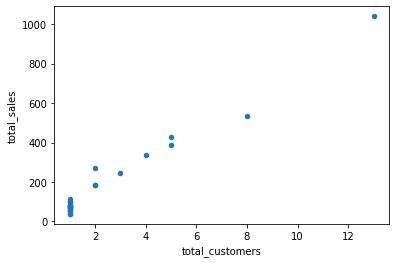

In [225]:
all_countries.plot.scatter(x='total_customers', y='total_sales')

In [226]:
all_countries.corr().plot.hexbin()

TypeError: hexbin() missing 2 required positional arguments: 'x' and 'y'

In [149]:
cc = """
CREATE VIEW include_other AS
    WITH c_sales AS (
    SELECT
        c.country,
        SUM(invoice.total) total_sales,
        country_cust.count total_customers,
        COUNT(invoice.invoice_id) num_orders,
        0 none
    FROM customer c
    LEFT JOIN invoice ON c.customer_id = invoice.customer_id
    INNER JOIN (SELECT country, COUNT(customer_id) count FROM customer GROUP by 1) country_cust ON country_cust.country = c.country
    GROUP BY 1
    ORDER BY 2 DESC
   ),
   included AS (
SELECT 
    country,
    total_sales,
    total_customers,
    num_orders,
    none
FROM c_sales
WHERE total_customers > 1
UNION
SELECT
    "Other",
    SUM(total_sales) total_sales,
    SUM(total_customers) total_customers,
    SUM(num_orders) num_orders,
    1 none
FROM c_sales
WHERE total_customers = 1
ORDER BY total_sales DESC
)
SELECT * FROM included
"""
run_command(cc)
q = """
SELECT  
    country,
    total_sales,
    total_customers,
    ROUND(total_sales / total_customers, 2) value_per_customer,
    ROUND(total_sales / num_orders, 2) value_per_order
FROM include_other

ORDER BY none
"""
run_query(q)


,country,total_sales,total_customers,value_per_customer,value_per_order
0,USA,1040.49,13,80.04,7.94
1,Canada,535.59,8,66.95,7.05
2,Brazil,427.68,5,85.54,7.01
3,France,389.07,5,77.81,7.78
4,Germany,334.62,4,83.66,8.16
5,Czech Republic,273.24,2,136.62,9.11
6,United Kingdom,245.52,3,81.84,8.77
7,Portugal,185.13,2,92.57,6.38
8,India,183.15,2,91.58,8.72
9,Other,1094.94,15,73.00,7.45


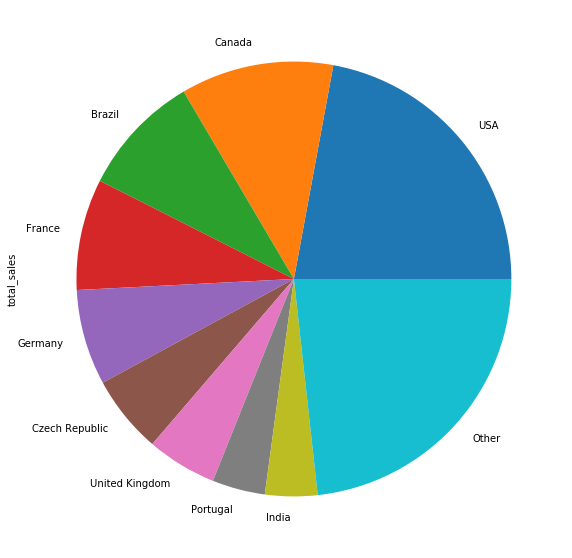

In [177]:
run_query(q).set_index('country').plot.pie('total_sales', figsize=(10,10), legend=False)

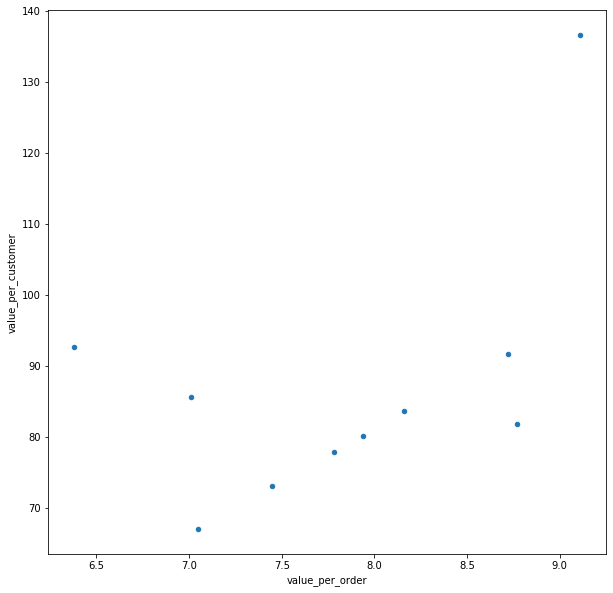

In [165]:
run_query(q).set_index('country').plot.scatter(x='value_per_order', y='value_per_customer', figsize=(10,10), legend=False)

In [ ]:
p = """
SELECT  
    country,
    total_sales,
    total_customers,
    ROUND(total_sales / total_customers, 2) value_per_customer,
    ROUND(total_sales / num_orders, 2) value_per_order
FROM include_other

ORDER BY none
"""

In [166]:
query_df = run_query(q).set_index('country')

In [170]:
query_df.drop('Other').corr()

,total_sales,total_customers,value_per_customer,value_per_order
total_sales,1.000000,0.983287,-0.350133,-0.136852
total_customers,0.983287,1.000000,-0.493502,-0.216451
value_per_customer,-0.350133,-0.493502,1.000000,0.480581
value_per_order,-0.136852,-0.216451,0.480581,1.000000


### The Final Query:

In [272]:
query_71 = """
WITH alb_tracks AS(
SELECT
    album_id,
    track_id songs_in_album
FROM track
WHERE COUNT(DISTINCT )
),
buy_tracks AS(
SELECT
    in_line.invoice_id,
    t.album_id,
    in_line.track_id
FROM invoice_line in_line
LEFT JOIN track t ON t.track_id = in_line.track_id
)
SELECT 
    invoice_id,
    COUNT(DISTINCT album_id) unique_albums
FROM buy_tracks
GROUP BY 1
HAVING unique_albums = 1
"""

In [274]:
run_query("SELECT album_id, COUNT(track_id) alb_songs FROM track GROUP BY 1 HAVING alb_songs > 2")

,album_id,alb_songs
0,1,10
1,3,3
2,4,8
3,5,15
4,6,13
5,7,12
6,8,14
7,9,8
8,10,14
9,11,12


In [284]:
query_72 = """
WITH alb_tracks AS(
SELECT
    album_id,
    track_id songs_in_album
FROM track
),
buy_tracks AS(
SELECT
    in_line.invoice_id,
    t.album_id,
    in_line.track_id
FROM invoice_line in_line
LEFT JOIN track t ON t.track_id = in_line.track_id
)
SELECT
    CASE
        WHEN (SELECT track_id FROM buy_tracks GROUP BY 1 EXCEPT SELECT songs_in_album FROM alb_tracks)
"""

In [286]:
run_query(query_72)

,track_id


In [403]:
command_72 ="""
CREATE VIEW test AS
    WITH alb_tracks AS(
SELECT
    album_id,
    COUNT(track_id) songs_in_album
FROM track
GROUP BY 1
HAVING songs_in_album > 2
),

buy_tracks AS(
SELECT
    in_line.invoice_id,
    t.album_id,
    in_line.track_id
FROM invoice_line in_line
LEFT JOIN track t ON t.track_id = in_line.track_id
INNER JOIN alb_tracks ON alb_tracks.album_id = t.album_id
),

inv_album AS(
SELECT
    invoice_id,
    album_id
FROM buy_tracks
GROUP BY 1
)

SELECT
    b.*,
    inv_album.album_id one_alb,
    
    CASE
        WHEN b.album_id = inv_album.album_id then "Match"
        ELSE "No Match"
        END
    AS match,
    alb_tracks.songs_in_album
FROM buy_tracks b
INNER JOIN inv_album ON b.invoice_id = inv_album.invoice_id
LEFT JOIN alb_tracks ON inv_album.album_id = alb_tracks.album_id


"""
run_command(command_72)

In [402]:
run_command("DROP VIEW test")

In [404]:
run_query("""
WITH matcher AS (
SELECT 
    test.*, 
    COUNT(DISTINCT test.track_id) song_match
    
FROM test 
WHERE match = 'Match' 
GROUP BY 1
HAVING songs_in_album = song_match
),
invoice_type AS (
SELECT
    inv.invoice_id,
    CASE
        WHEN inv.invoice_id in (SELECT invoice_id FROM matcher) THEN 'Album Purchase'
        ELSE 'Song Purchase'
        END
    AS purchase_type
FROM invoice inv
ORDER BY 1
)
SELECT
    purchase_type,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) as Float)/614 percent
FROM invoice_type
GROUP BY 1
""")

,purchase_type,number_of_invoices,percent
0,Album Purchase,111,0.180782
1,Song Purchase,503,0.819218
